# Practical 3

In [1]:
import numpy as np
from matplotlib import pyplot as plt
#import cvxopt  # needed later on

# Task 0: Preliminaries

This time we will work with a synthetic 2d dataset to facilitate visualization and be able to focus on the algorithms rather than spending energy to understand the dataset. The dataset consists of two classes and two predictors. Below we load the dataset and plot it.

(250, 2)
(250,)


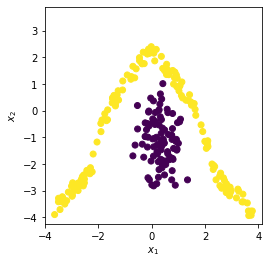

In [2]:
X_2d, t_2d = np.load('data/nonlin_2d_data.npy')[:, :2], np.load('data/nonlin_2d_data.npy')[:, 2]

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=t_2d)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.axis('square');

print(np.shape(X_2d))
print(np.shape(t_2d))

### Task 0.1

Apply logistic regression and LDA to the provided data, compute classification accuracy and plot the predictions. How do they perform? You're welcome to use sklearn for this task.

In [3]:
# Standardization
def preprocess(X):
    m = len(X[0,:])
    d = X.copy()
    for i in range(m):
        d[:,i] = (d[:,i] - d[:,i].mean()) / d[:,i].std()
    return d

In [4]:
# Split data in training and test set
def split_data(X, y, frac=0.3, seed=None):
    if seed is not None:
        np.random.seed(seed)

    ### implement the function here
    idx = np.arange(X.shape[0])
    idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

    test_idx = idx_shuffled[:int(X.shape[0]*frac)]
    train_idx = idx_shuffled[int(X.shape[0]*frac):X.shape[0]]

    X_test = X[test_idx]
    y_test = y[test_idx]
    print('Test set shapes (X and y)', X_test.shape, y_test.shape)

    X_train = X[train_idx]
    y_train = y[train_idx]
    print('Training set shapes (X and y):', X_train.shape, y_train.shape)

    return X_train, X_test, y_train, y_test


Test set shapes (X and y) (75, 2) (75,)
Training set shapes (X and y): (175, 2) (175,)
Accuracy:  0.52


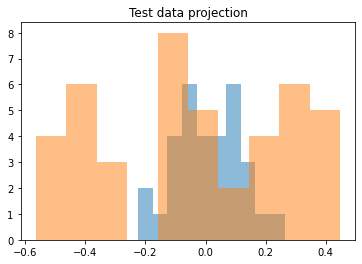

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

X_norm = preprocess(X_2d)
X_train, X_test, t_train, t_test = split_data(X_norm, t_2d)

model = LogisticRegression(penalty='none').fit(X_train, t_train)
y_pred = model.predict(X_test)
w = model.coef_[0]
plt.title('Test data projection')
_ = plt.hist((X_test.dot(w))[t_test==np.unique(t_test)[0]],label='Class 0',alpha=0.5)
_ = plt.hist((X_test.dot(w))[t_test==np.unique(t_test)[1]],label='Class 1',alpha=0.5)

score_noreg = metrics.accuracy_score(t_test, y_pred)
print('Accuracy: ',score_noreg)

(array([4., 6., 3., 0., 6., 7., 2., 4., 6., 5.]),
 array([-0.00326474, -0.00268242, -0.00210009, -0.00151777, -0.00093545,
        -0.00035312,  0.0002292 ,  0.00081152,  0.00139385,  0.00197617,
         0.00255849]),
 <BarContainer object of 10 artists>)

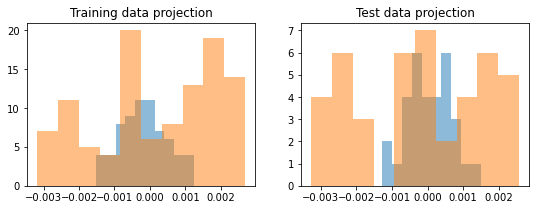

In [6]:
# LDA
def compute_lda_weights(X, y):
    length = X.shape[1]
    unique_classes = np.unique(y)
    num_classes = len(unique_classes)

    between_class_feature_means = []
    for i in unique_classes:
        between_class_feature_means.append(np.array((X[y==i].mean(axis=0))))

    sw_scatter_matrix = np.zeros((length,length))
    for i in range(num_classes):    
        s = np.zeros((length,length))
        mc, x_c = between_class_feature_means[i], X[y==unique_classes[i]]
        sw_scatter_matrix += (x_c - mc).T.dot((x_c - mc))

    feature_means = X.mean(axis=0)
    sb_scatter_matrix = np.zeros((length,length))
    for i in range(num_classes):
        n = X[y==unique_classes[i]].shape[0]
        mc, m = between_class_feature_means[i].reshape(length,1), feature_means.reshape(length,1)
        sb_scatter_matrix += n * (mc - m).dot((mc - m).T)

    w = np.linalg.inv(sw_scatter_matrix).dot(between_class_feature_means[1]-between_class_feature_means[0])

    return between_class_feature_means[0], between_class_feature_means[1], between_class_feature_means[1]-between_class_feature_means[0], w

m0, m1, mdiff, w_lda = compute_lda_weights(X_train, t_train)
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].set_title('Training data projection')
ax[0].hist((X_train[t_train==np.unique(t_train)[0]].dot(w_lda)),label='class 0',alpha=0.5)
ax[0].hist((X_train[t_train==np.unique(t_train)[1]].dot(w_lda)),label='class 1',alpha=0.5)
ax[1].set_title('Test data projection')
ax[1].hist((X_test.dot(w_lda.T))[t_test==np.unique(t_test)[0]],label='class 0',alpha=0.5)
ax[1].hist((X_test.dot(w_lda.T))[t_test==np.unique(t_test)[1]],label='class 1',alpha=0.5)

### Task 0.2

Implement the Gaussian RBF and visualize the pairwise similarities of `x`.

In [7]:
x = np.stack([np.sin(np.linspace(0, 8, 15)), np.cos(np.linspace(0, 7, 15))]).T
print(np.shape(x))

(15, 2)


In [8]:
# RBF kernel
def rbf_kernel(x, y, sigma, gamma=5):
    return np.exp(-gamma*np.linalg.norm(x-y, 2)**2/(sigma**2))
pairwise_matrix = np.zeros((len(x), len(x)))

rc = 0
for row in x:
    cc = 0
    for col in x:
        pairwise_matrix[rc,cc] = rbf_kernel(row, col, 5)
        cc += 1
    rc += 1

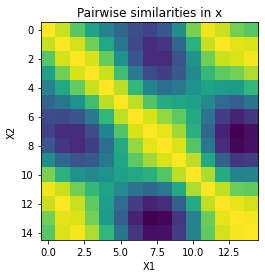

In [9]:
# Visualize pairwise similarities
plt.title('Pairwise similarities in x')
plt.xlabel('X1')
plt.ylabel('X2')
_ = plt.imshow(pairwise_matrix)

# Task 1: Kernel Discriminant Analysis

We will be implementing Kernel Discriminant Analysis, a nonlinear extension to LDA based on the kernel trick, following the original paper by Mika, Rätsch, Weston, Schölkopf and Müller (PDF on StudIP). Note, this is the original notation from the paper, mind the difference betweeen the matrix $M$ and the vectors $M_1, M_2$.

The goal of Kernel Discriminant Analysis is find a vector of $\alpha$'s that maximizes
$$ J(\alpha) = \frac{\alpha^T M \alpha}{\alpha^T N \alpha} $$
where
$$M := (M_1 - M_2)(M_1 - M_2)^T \text{ with } (M_i)_j = \frac{1}{l_i} \sum_{k=1}^{l_i} k(x_j, x_k^i)$$ and
$$N= \sum_{j=1,2} K_j (I - 1_{l_j}) K_j^T$$
Here, the number of samples for class $j$ is denoted by $l_j$. In the definition of $N$, $(K_{j})_{n,m} = k(x_n, x_m^j)$, $I$ is the identity matrix and $1_{l_j}$ is a matrix with each entry equal to $1/l_j$. $M_1, M_2$ have shape $(l_0 + l_1)$ each, $N$ and $M$ have shape $(l_0 + l_1) \times (l_0 + l_1)$.

We obtain the optimal solution by $\alpha = N^{-1}(M_1 - M_0)$. Note that you may have to regularize $N^{-1}$ for numerical stability (see paper or Wikipedia).

Prediction for an arbitrary sample $x$ is then carried out by building a weighted sum over it's kernel with the samples from the training set.

1. Implement a function `kda(X, t, kernel)` that carries out Kernel Discriminant Analysis on the data $X,t$ and returns a vector `alpha`.
2. Implement a function `def predict(x, X, alpha, kernel)`.
3. Visualize results given a linear kernel and a Gaussian Radial Basis Function kernel.

Use the following snippet as a starting point.

In [15]:
def kda(X, t, kernel):
    
    l = [(t == 0).sum(), (t == 1).sum()] # Number of class entries
    X_split = X[(t == 0)], X[(t == 1)] # X split into classes
    M = np.ones((2, len(X))) # 2 rows of m entries
    K = np.ones((len(X), l[0])), np.ones((len(X), l[1]))
    
    for i in range(0,len(X[0])):
        for j in range(0,len(X)):
            temp_sum = 0.0
            for k in range(l[i]):
                k_out = linear_kernel(X[j], X_split[i][k]) if kernel==0 else rbf_kernel(X[j], X_split[i][k])
                K[i][j][k] = k_out
                temp_sum += k_out
            M[i,j] = temp_sum
    
    # Calculate N
    N1 = K[0] * (np.identity(len(K[0])) @ np.full(np.shape(K[0]), 1/l[0])) @ K[0].T
    N2 = K[1] * (np.identity(len(K[1])) @ np.full(np.shape(K[1]), 1/l[1])) @ K[1].T
    N = N1+N2

    # Regularize N
    N = N + 3*np.identity(len(N))
    
    # Alpha
    alpha = np.linalg.inv(N) @ (M[1]-M[0])
    return(alpha)

def predict(x, X, alpha, kernel):
    y_pred = []
    for x_m in x:
        y_sum = 0
        for x_n, alp in zip(X, alpha):
            y_sum = y_sum + alp*kernel(x_n, x_m)
        y_pred.append(y_sum)
    return np.array(y_pred)

def rbf_kernel(x_n, x_m, sigma=5, gamma=5):
    return np.exp(-gamma*np.linalg.norm(x_n-x_m, 2)**2/(sigma**2))

def linear_kernel(x_n, x_m):
    return (x_n.T.dot(x_m))**2


In [11]:
# Perform KDA with linear and RBF kernel
alpha_lin = kda(X_train, t_train, 0)
alpha_rbf = kda(X_train, t_train, 1)

p_lin = predict(X_test, X_train, alpha_lin, linear_kernel)
p_rbf = predict(X_test, X_train, alpha_rbf, rbf_kernel)


(array([ 2.,  1.,  1.,  1.,  3.,  1.,  3.,  9., 16.,  6.]),
 array([-3.87764907,  3.48135933, 10.84036772, 18.19937612, 25.55838451,
        32.91739291, 40.2764013 , 47.6354097 , 54.99441809, 62.35342649,
        69.71243488]),
 <BarContainer object of 10 artists>)

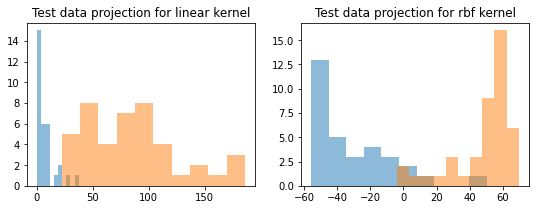

In [12]:
# Visualize results
y_lin_split = p_lin[(t_test == 0)], p_lin[(t_test == 1)]
y_rbf_split = p_rbf[(t_test == 0)], p_rbf[(t_test == 1)]
#print(y_test_split)
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ax[0].set_title('Test data projection for linear kernel')
ax[0].hist(y_lin_split[0],label='class 0',alpha=0.5)
ax[0].hist(y_lin_split[1],label='class 1',alpha=0.5)
ax[1].set_title('Test data projection for rbf kernel')
ax[1].hist(y_rbf_split[0],label='class 0',alpha=0.5)
ax[1].hist(y_rbf_split[1],label='class 1',alpha=0.5)

### Task 1.2

Which value would you use as a threshold to separate the classes? Use this threshold value to visualize the decision boundaries in a 2d grid (see example code below) and make predictions on the test set.

<function <lambda> at 0x00000173C440F0D0>


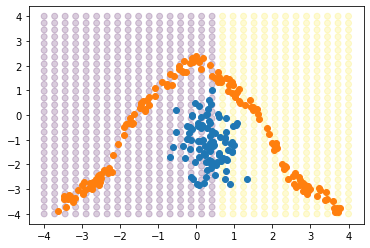

In [13]:
def plot_decision_boundary(predict_fn):
    ''' Plot decision boundary.

    predict_fn: function handle to a predict function that takes
                as input a data point x and outputs the predicted
                label t
    '''
    grid = np.meshgrid(np.linspace(-4, 4, 30), np.linspace(-4, 4, 30))
    grid_x, grid_y = grid[0].flatten(), grid[1].flatten()
    grid_t = np.array([
        predict_fn([x, y]) for x, y, in zip(grid_x, grid_y)])
    plt.scatter(grid_x, grid_y, c=grid_t, alpha=0.2)


# The following example has the decision boundary at x[0] = 0.5
predict_fn = lambda x: x[0] > 0.5
print(predict_fn)
plot_decision_boundary(predict_fn)
X_split = X_2d[(t_2d == 0)], X_2d[(t_2d == 1)]
plt.scatter(X_split[0][:,0],X_split[0][:,1])
plt.scatter(X_split[1][:,0],X_split[1][:,1])

In [14]:
# Visualize decision boundaries
